In [21]:
import os
import librosa
import soundfile as sf
import numpy as np

from IPython import display
import matplotlib.pyplot as plt
import librosa.display

# Input and output directories
input_dir = "train/audio"
noise_dir = "train/_background_noise_"
output_dir = "processed_train"

# Parameters
sample_rate = 16000  # Desired sample rate
max_duration = 1   # Duration in seconds
max_length = int(sample_rate * max_duration)

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load audio_list

def load_wav_files(directory):
    """
    Enumerate over a directory, find .wav files, and load them into a list.

    Parameters:
        directory (str): Path to the directory to search.
        sample_rate (int): Target sample rate for loading audio files.

    Returns:
        list of tuples: A list of tuples where each tuple contains the file path and audio data.
    """
    audio_list = []

    # Walk through the directory
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                # Full file path
                file_path = os.path.join(root, file)
                # Load the audio file
                audio, sr = librosa.load(file_path)
                # Append to the list
                class_name = os.path.basename(os.path.dirname(file_path))
                audio_list.append((audio, class_name, file_path))

    return audio_list




In [22]:
# Remove silence

def remove_silence(audio):
    audio_trimmed, _ = librosa.effects.trim(audio, top_db=60)
    return audio_trimmed

# Randomly pad with zeros

def standardize(audio):
    max_length = sample_rate * max_duration
    length = len(audio)
    if length < max_length:
        num_zeros = max_length - length
        for _ in range(num_zeros):
            zero_position = np.random.randint(0, length)
            new_audio = np.insert(audio, zero_position, 0)
        return new_audio
    elif length > max_length:
        max_length = sample_rate * max_duration
        start = np.random.randint(0, len(audio) - max_length)
        return audio[start:start + max_length]
    return audio

# Add random background noise

def add_background_noise(noise, audio, snr_db=10):
    audio_length = len(audio)
    noise_length = len(noise)
    if noise_length < audio_length:
        # Repeat noise if it's shorter than audio
        repeats = int(np.ceil(audio_length / noise_length))
        noise = np.tile(noise, repeats)[:audio_length]
    elif noise_length > audio_length:
        # Crop noise randomly if it's longer than audio
        start = np.random.randint(0, noise_length - audio_length)
        noise = noise[start:start + audio_length]

    # Compute the power of the audio and noise
    audio_power = np.mean(audio ** 2)
    noise_power = np.mean(noise ** 2)

    # Adjust noise to achieve the desired SNR
    target_noise_power = audio_power / (10 ** (snr_db / 10))
    scaling_factor = np.sqrt(target_noise_power / noise_power)
    noise = noise * scaling_factor

    # Add the noise to the audio
    noisy_audio = audio + noise

    # Ensure the output is in the same range as the input
    noisy_audio = np.clip(noisy_audio, -1.0, 1.0)  # Assuming input audio is in the range [-1, 1]

    return noisy_audio

# normalize audio
def normalize_audio(audio):
    """Normalize audio to the range [-1, 1]."""
    audio = audio / np.max(np.abs(audio))  # Normalize to the range [-1, 1]
    return audio

In [24]:
# Function to perform noise analysis and visualization
def visualize_noise_effect(original_audio, noisy_audio, sample_rate, class_name):
    plt.figure(figsize=(14, 4))
    plt.plot(noisy_audio, label="Noisy Signal", alpha=0.7)
    plt.plot(original_audio, label="Original Signal", alpha=0.7)
    plt.legend()
    plt.title(f"Original vs Noisy Signal - Class: {class_name}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

    print("Original audio:")
    display.display(display.Audio(original_audio, rate=sample_rate))
    
    print("Noisy audio:")
    display.display(display.Audio(noisy_audio, rate=sample_rate))

    # Spectrogram comparison
    spectrogram_original = librosa.feature.melspectrogram(y=original_audio, sr=sample_rate, n_mels=128, fmax=8000)
    log_spectrogram_original = librosa.power_to_db(spectrogram_original, ref=np.max)

    spectrogram_noisy = librosa.feature.melspectrogram(y=noisy_audio, sr=sample_rate, n_mels=128, fmax=8000)
    log_spectrogram_noisy = librosa.power_to_db(spectrogram_noisy, ref=np.max)

    # Plot original spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_spectrogram_original, sr=sample_rate, x_axis='time', y_axis='mel', fmax=8000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Original Spectrogram")
    plt.show()

    # Plot noisy spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_spectrogram_noisy, sr=sample_rate, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Noisy Spectrogram")
    plt.show()

In [26]:
def preprocess_and_save(
    file_path,
    audio,
    class_name,
    noise_list,
    visualization_count=None,
    max_visualizations_per_class=1,
    visualize_classes=None,
):

    if visualization_count is None:
        visualization_count = {}

    if visualize_classes is None:
        visualize_classes = set()  # Default to an empty set if not provided

    np.random.seed(42)

    # Remove silence
    audio_t = remove_silence(audio)

    # Add noise
    random_noise_index = np.random.randint(0, len(noise_list) - 1)
    noisy_audio = add_background_noise(noise_list[random_noise_index][0], audio_t)

    # Visualize only if the class is in the visualize_classes list and hasn't reached the limit
    if (
        class_name in visualize_classes
        and visualization_count.get(class_name, 0) < max_visualizations_per_class
    ):
        visualize_noise_effect(
            original_audio=audio,
            noisy_audio=noisy_audio,
            sample_rate=sample_rate,
            class_name=class_name,
        )
        # Increment visualization count for the class
        visualization_count[class_name] = visualization_count.get(class_name, 0) + 1

    # Pad or crop to standardize length
    audio_t = standardize(noisy_audio)

    # Save the preprocessed audio
    output_class_dir = os.path.join(output_dir, class_name)
    os.makedirs(output_class_dir, exist_ok=True)  # Create class directory if it doesn't exist
    filename = os.path.basename(file_path)
    output_path = os.path.join(output_class_dir, filename)
    sf.write(output_path, audio_t, sample_rate)

    return output_path

In [27]:
# Process all files, preserving the directory structure
sample_sounds = load_wav_files(input_dir)
noise = load_wav_files(noise_dir)

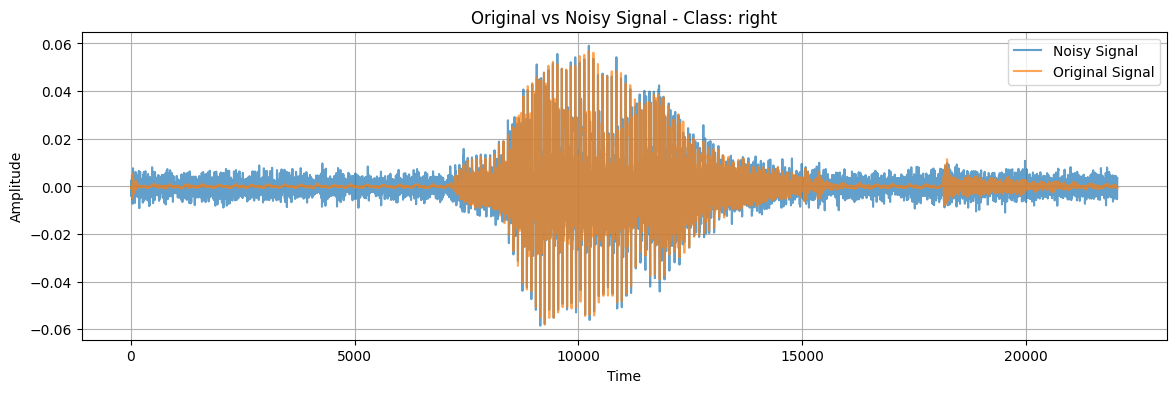

Original audio:


Noisy audio:


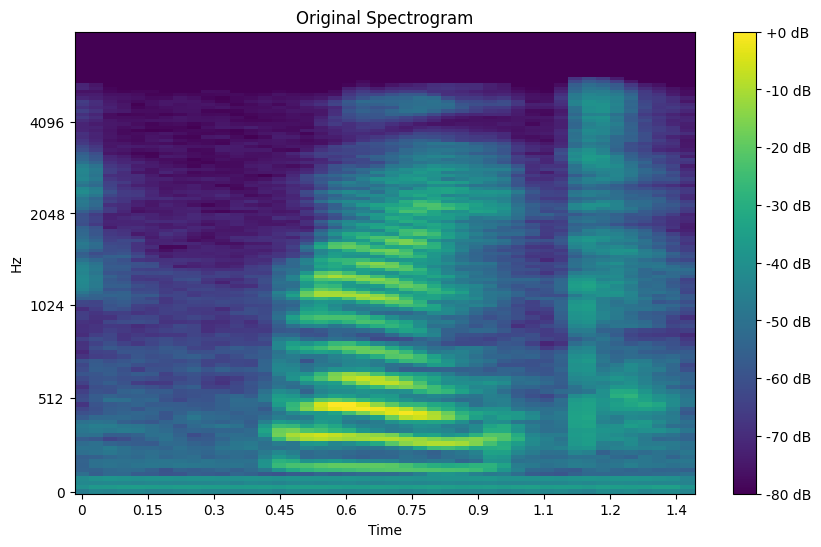

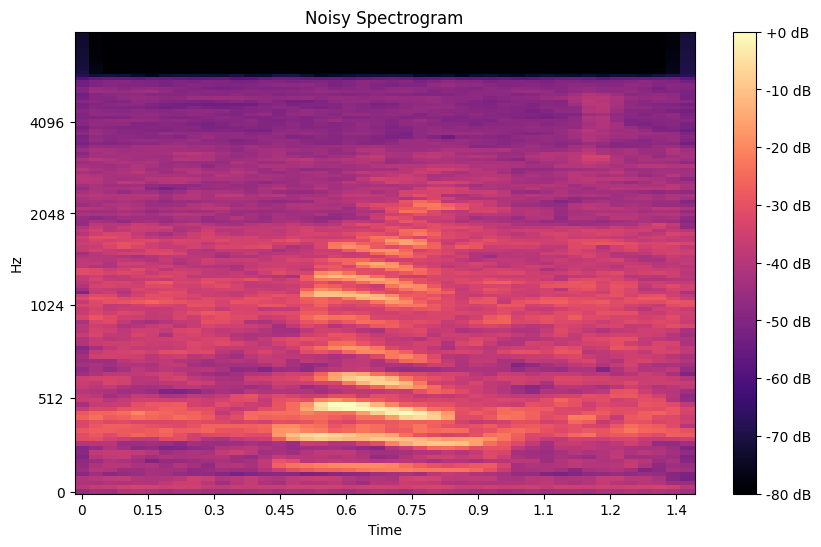

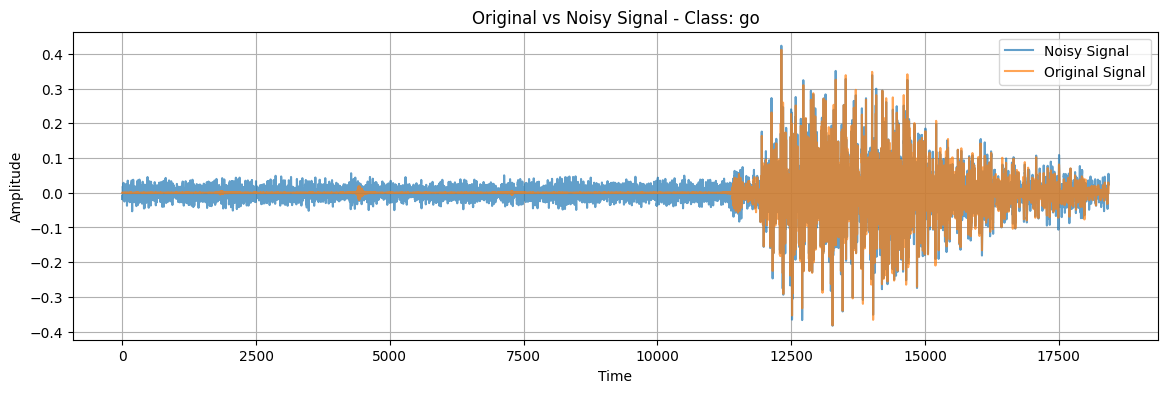

Original audio:


Noisy audio:


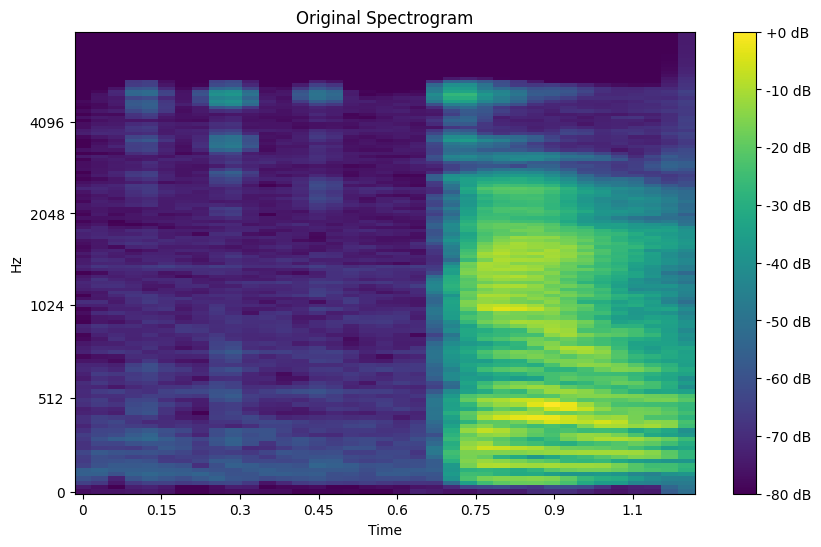

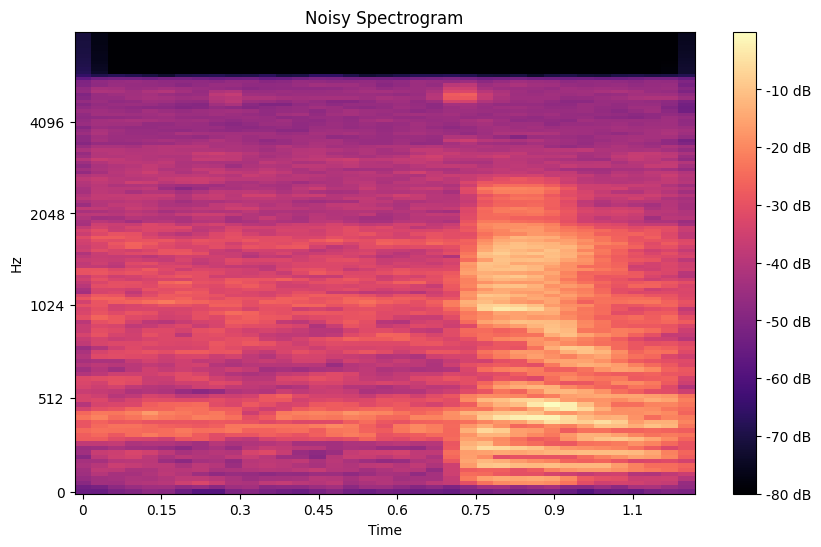

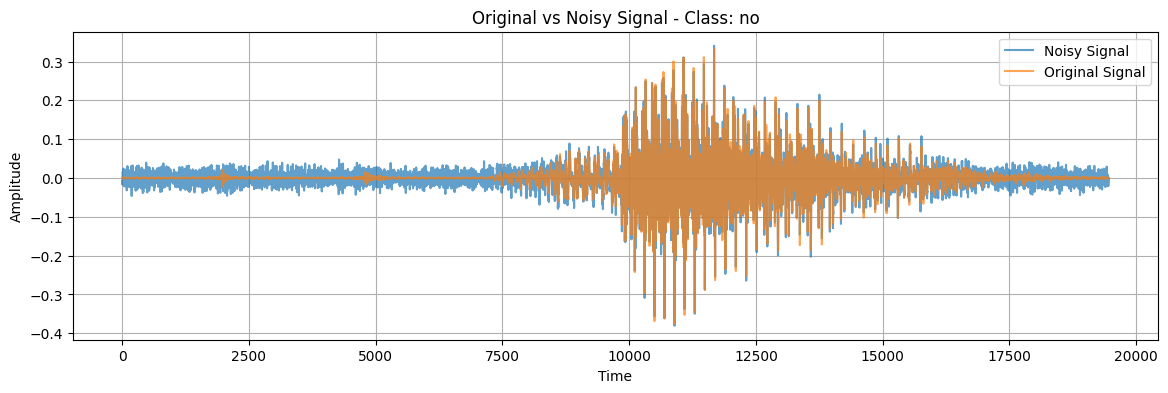

Original audio:


Noisy audio:


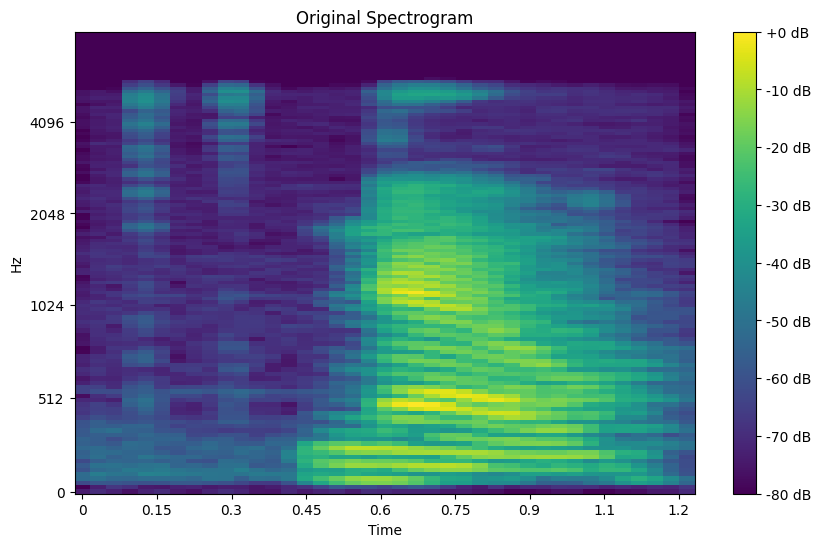

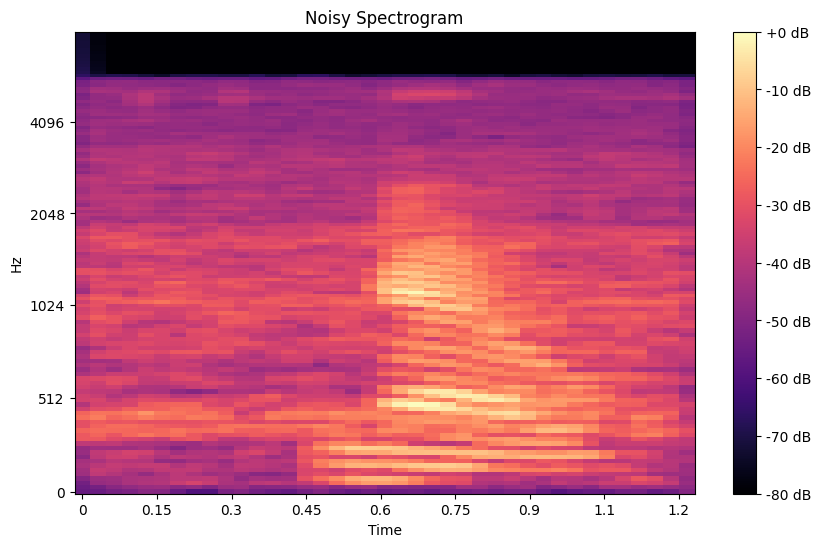

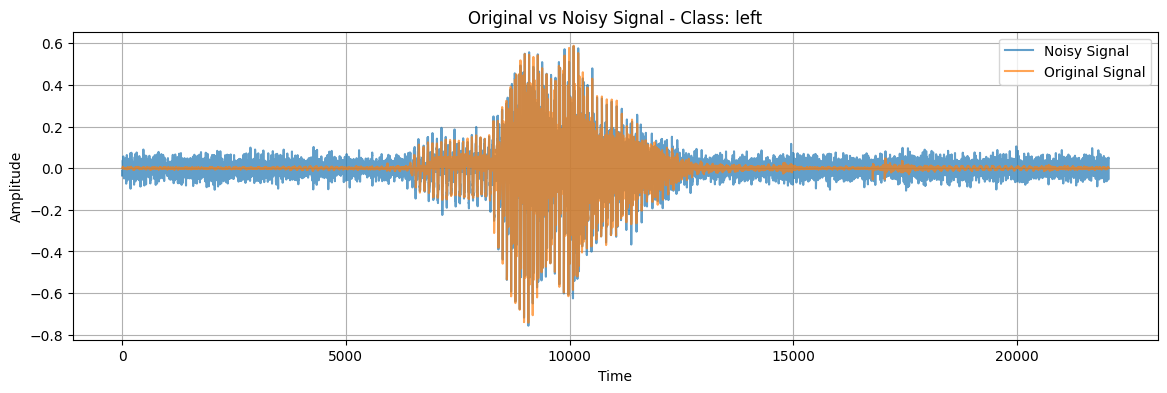

Original audio:


Noisy audio:


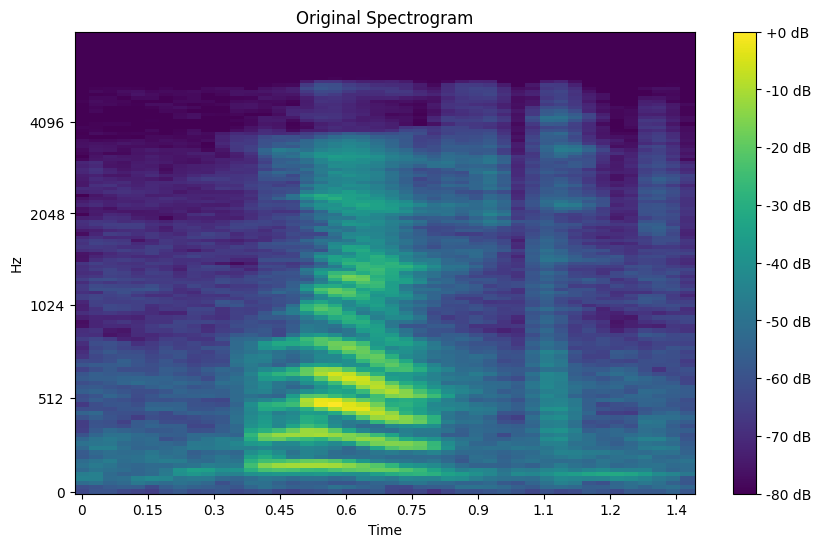

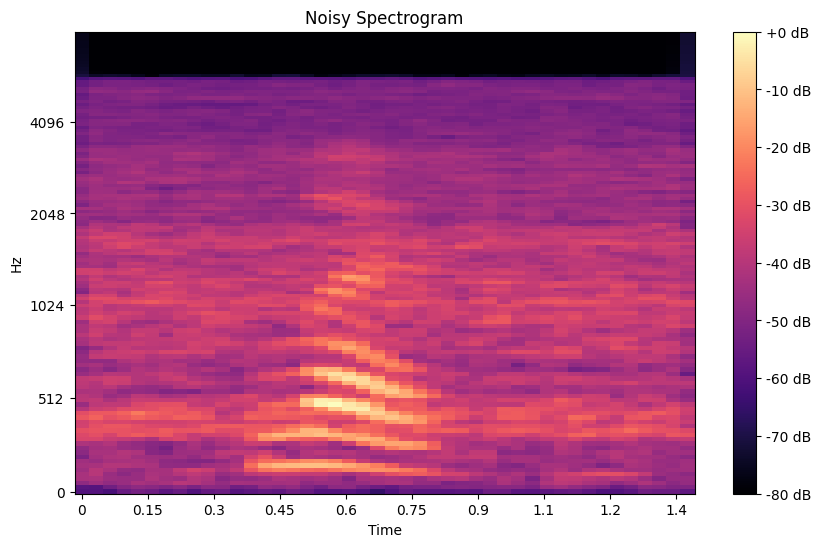

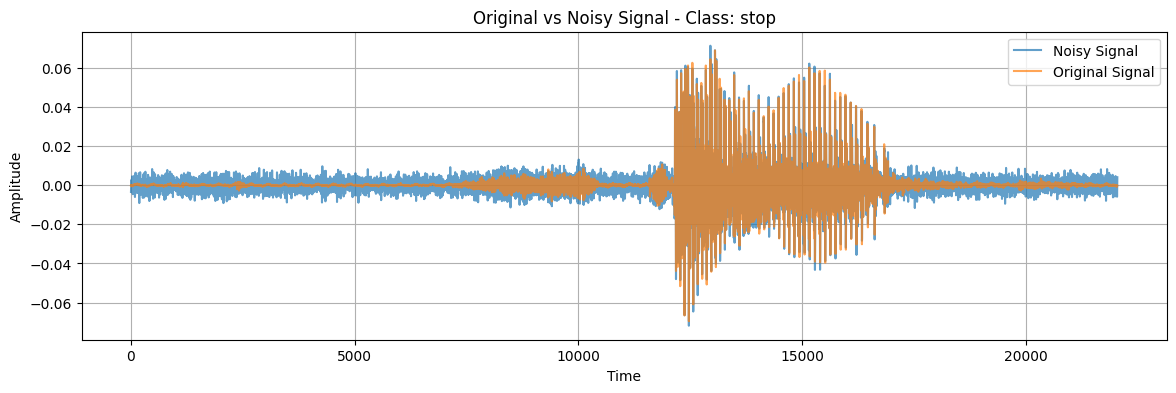

Original audio:


Noisy audio:


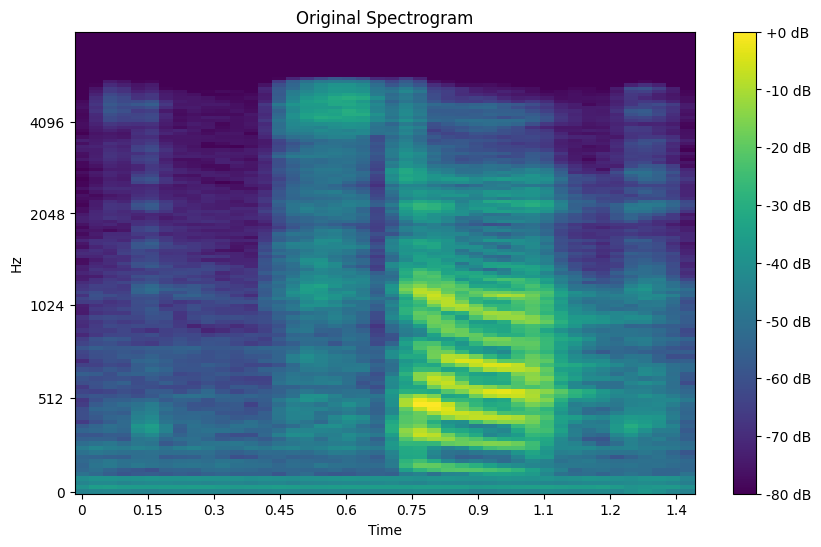

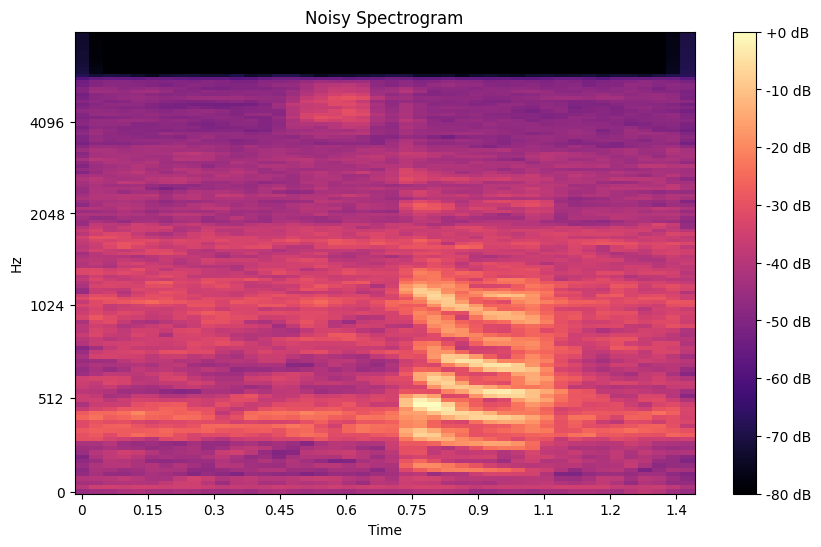

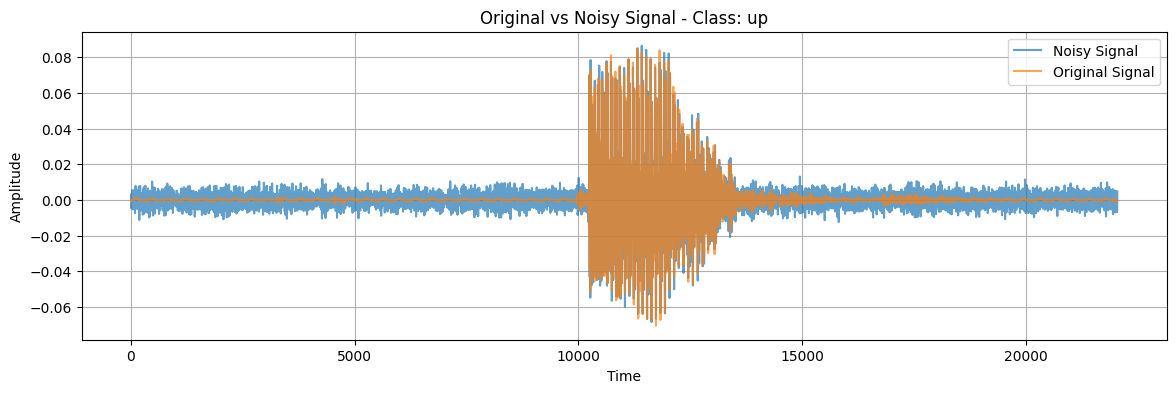

Original audio:


Noisy audio:


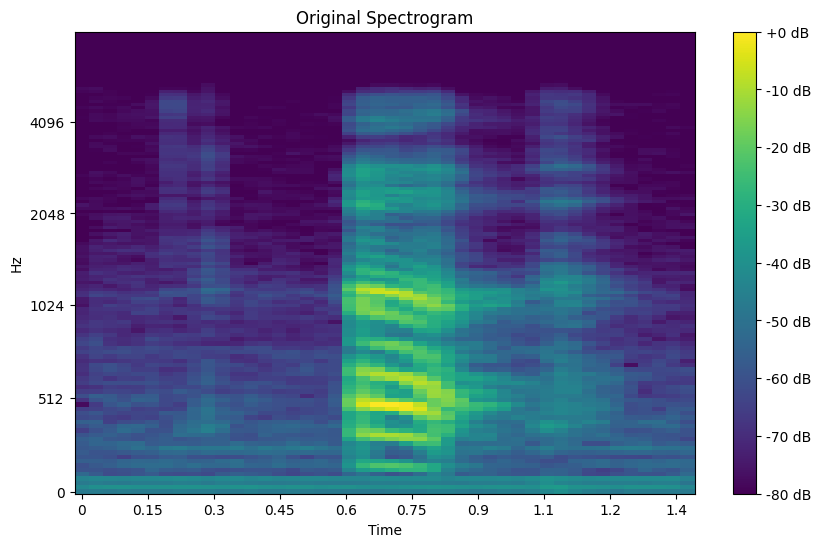

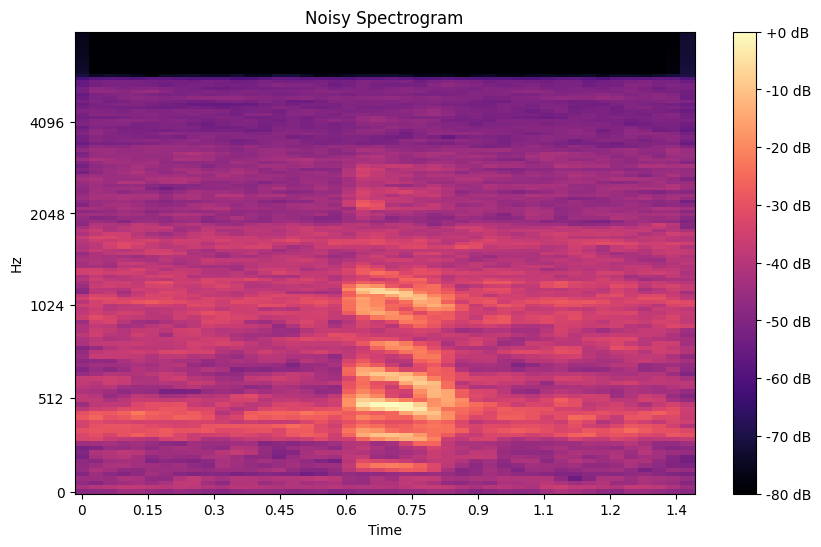

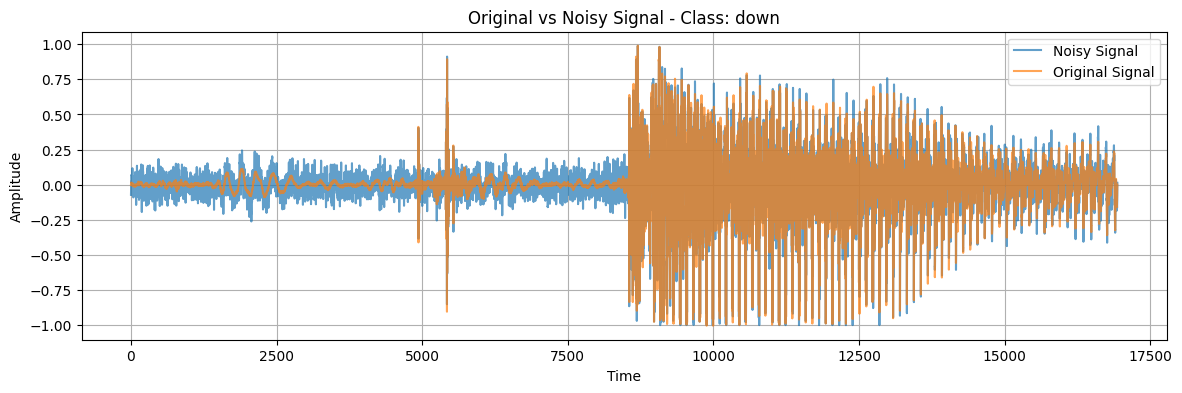

Original audio:


Noisy audio:


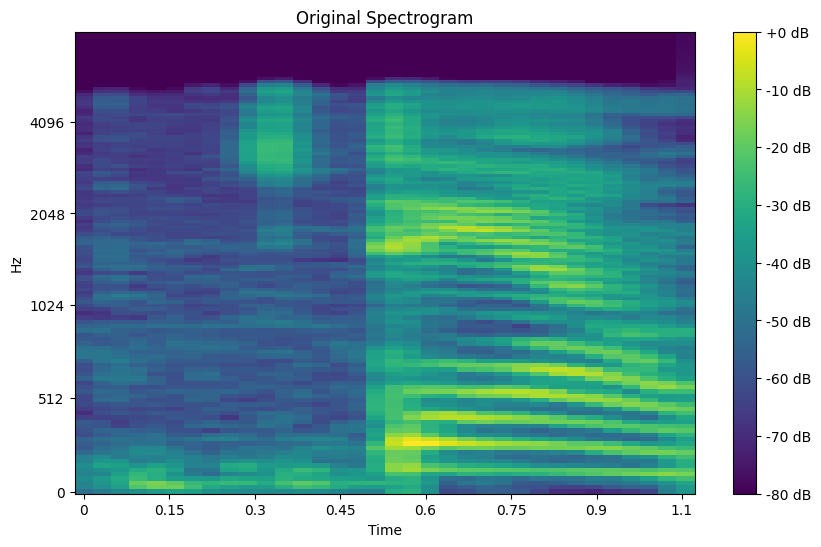

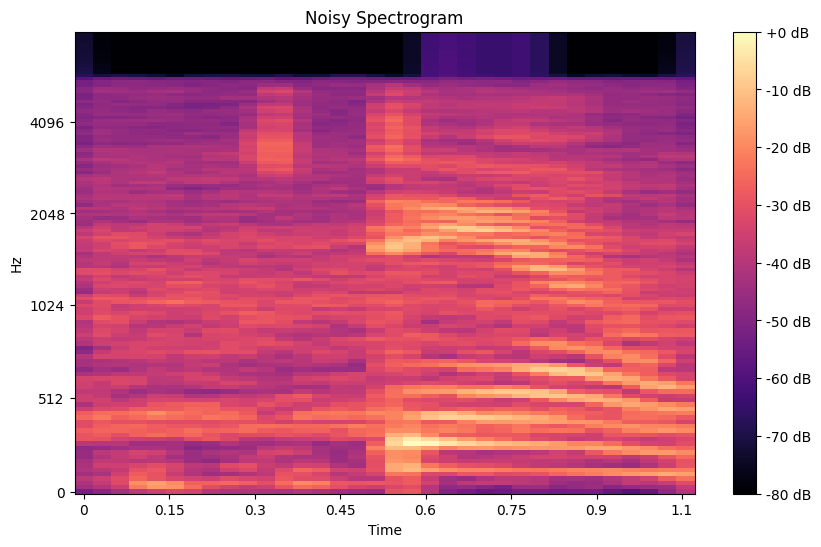

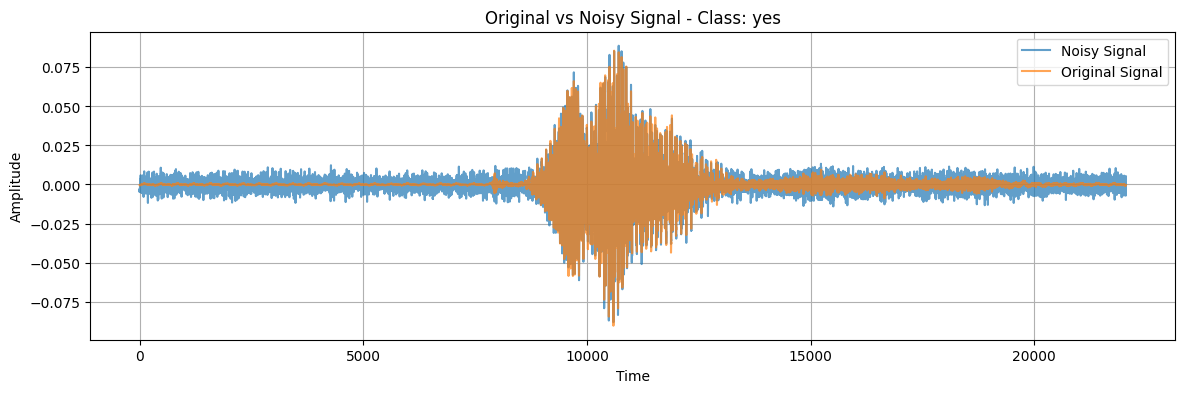

Original audio:


Noisy audio:


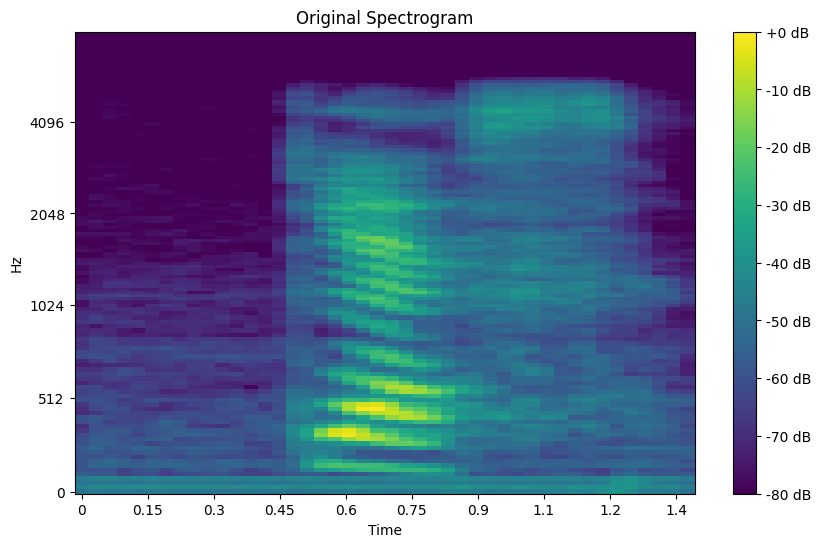

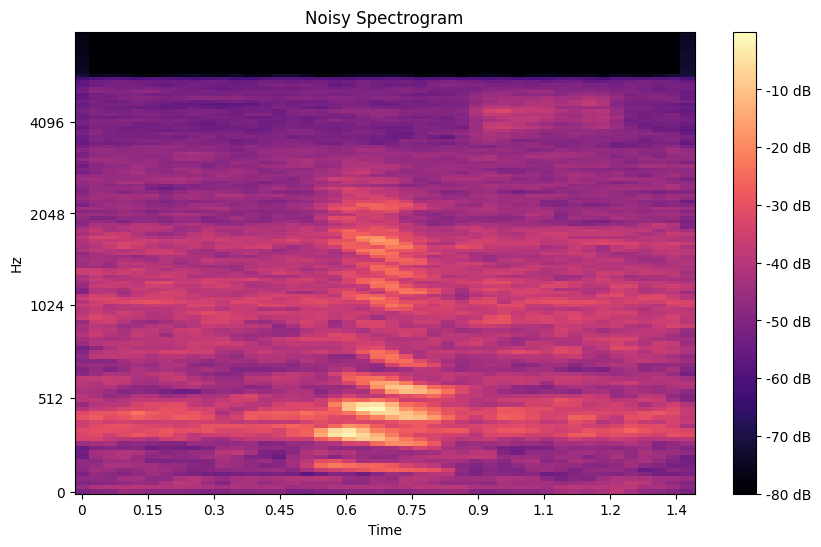

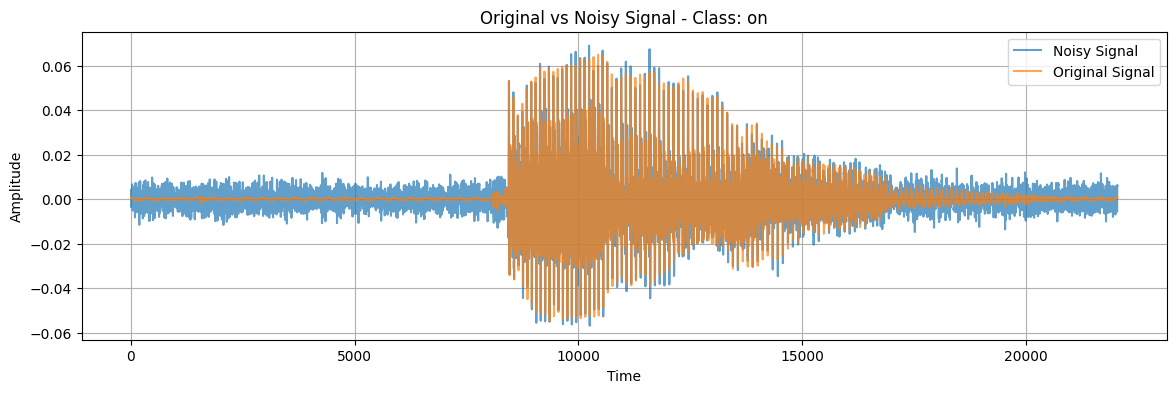

Original audio:


Noisy audio:


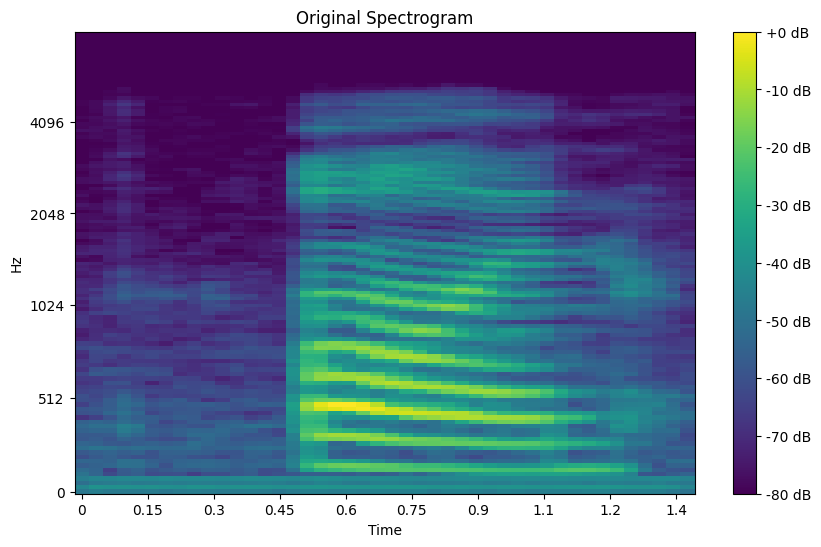

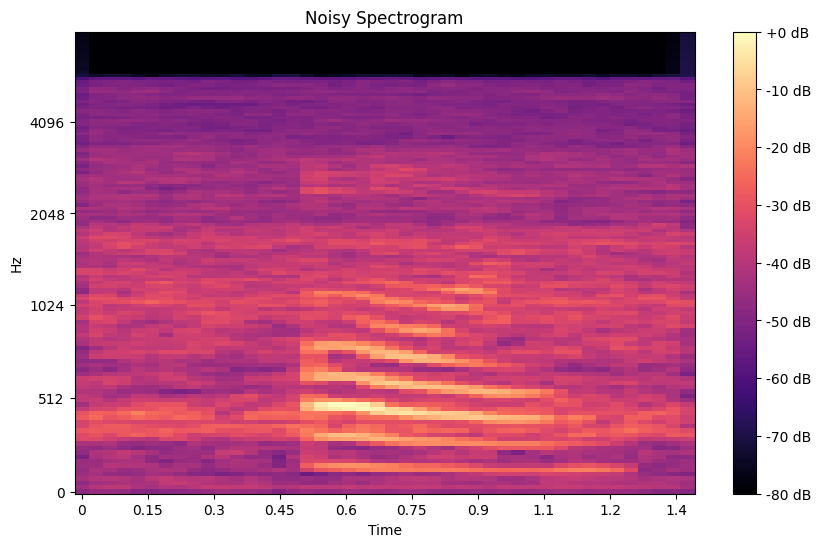

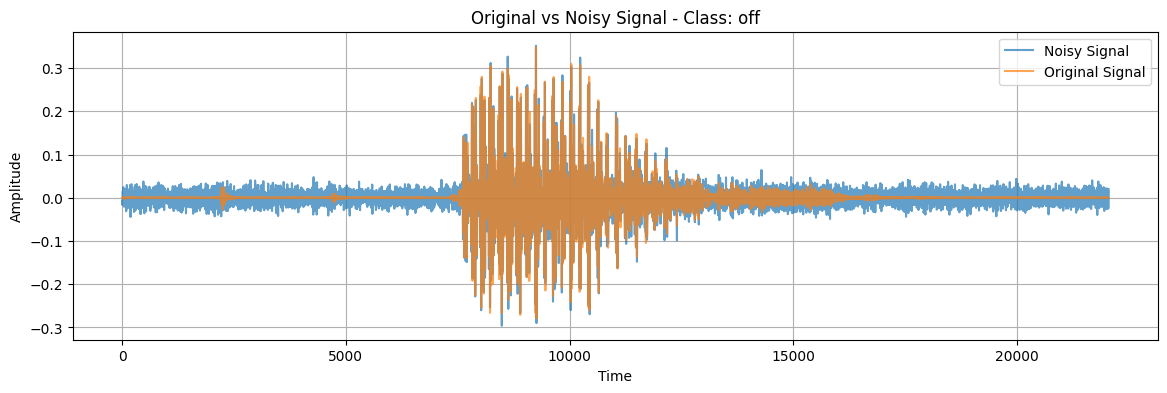

Original audio:


Noisy audio:


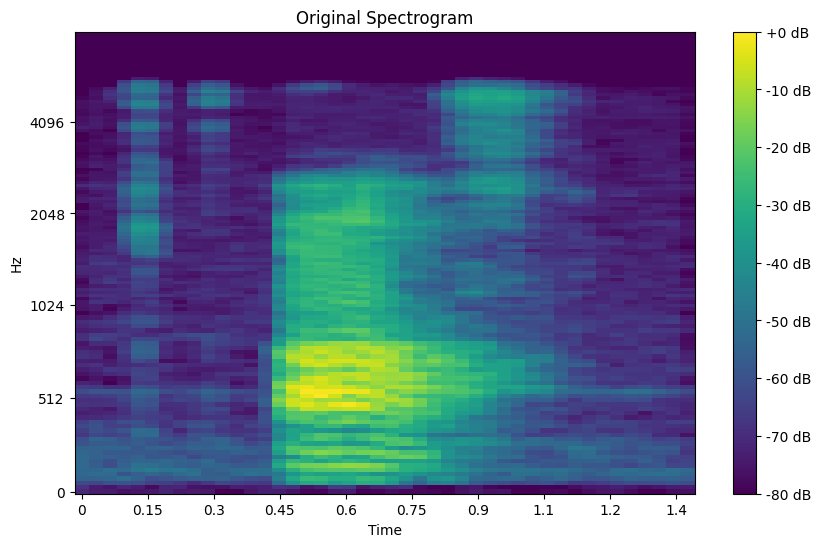

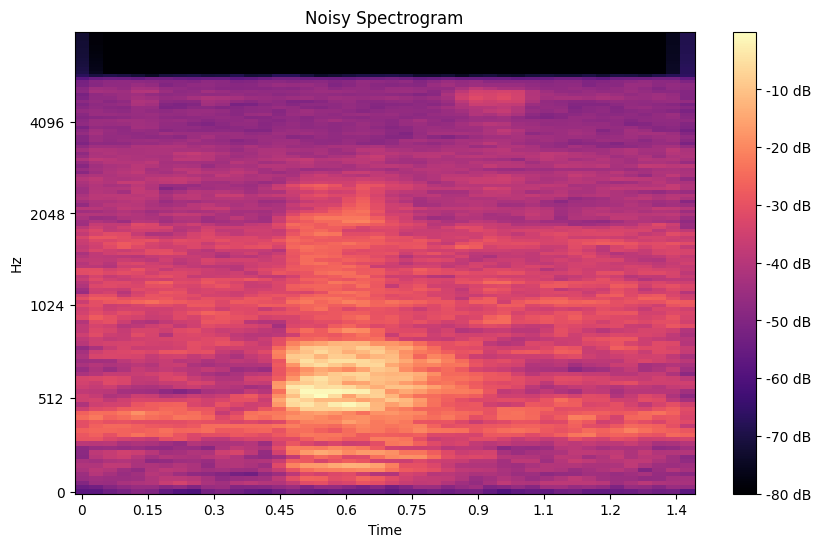

In [28]:
classes_to_visualize = {'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'}

# Dictionary to track visualizations per class
visualization_count = {}

# Process files
for audio, class_name, file_path in sample_sounds:
    preprocess_and_save(
        file_path=file_path,
        audio=audio,
        class_name=class_name,
        noise_list=noise,
        visualization_count=visualization_count,
        max_visualizations_per_class=1,  # Change this to control the number of visualizations per class
        visualize_classes=classes_to_visualize,
    )